In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from src.utils_graph import create_graph, subgraph_dijkstra 
from src.utils_data import load_PeMS04_flow_data, TimeSeriesDataset, my_data_loader,createLoaders, preprocess_PeMS_data, plot_prediction
from src.models import LSTMModel, testmodel 
from src.fedutil import local_dataset, fed_training_plan
from src.metrics import calculate_metrics
import networkx as nx


In [4]:
#Load traffic flow dataframe and graph dataframe from PEMS
PeMS, distance = load_PeMS04_flow_data()


In [5]:
PeMS, adjmat, meanstd_dict = preprocess_PeMS_data(PeMS,distance,0,99,True,True,False,False)

c:\Users\mbenali\Desktop\Federated-Traffic-Flow-Forecasting\src\utils_data.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PeMS[df_PeMS.columns[i]] = smoothed_values
c:\Users\mbenali\Desktop\Federated-Traffic-Flow-Forecasting\src\utils_data.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column]-colmean
c:\Users\mbenali\Desktop\Federated-Traffic-Flow-Forecasting\src\utils_data.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [6]:
G = create_graph(distance)
subgraph = subgraph_dijkstra(G,0,99)
PeMS = PeMS[list(subgraph.nodes)]

During our last experiment we saw that our nodes of interest are : 
[118,168,261]

In [7]:
goodnodes = [118,168,261]
for i in goodnodes:
    print("Nodes {} with mean traffic flow : {}".format(i,meanstd_dict[i]['mean']))
    print("Nodes {} with standard deviation : {}".format(i,meanstd_dict[i]['std']))

Nodes 118 with mean traffic flow : 236.86296221006594
Nodes 118 with standard deviation : 149.88423666202848
Nodes 168 with mean traffic flow : 242.83818140738057
Nodes 168 with standard deviation : 99.08987996156547
Nodes 261 with mean traffic flow : 240.56893219996417
Nodes 261 with standard deviation : 138.274708369788


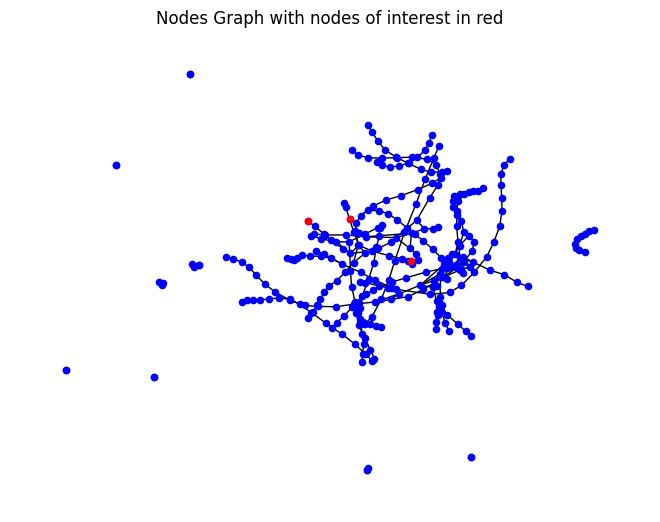

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


pos = nx.spring_layout(G)

nx.draw(G, pos=pos, node_color='b', node_size=20)
nx.draw_networkx_nodes(G, pos=pos, nodelist=[118,168,261], node_color='r', node_size=20)
plt.title("Nodes Graph with nodes of interest in red")
plt.show()

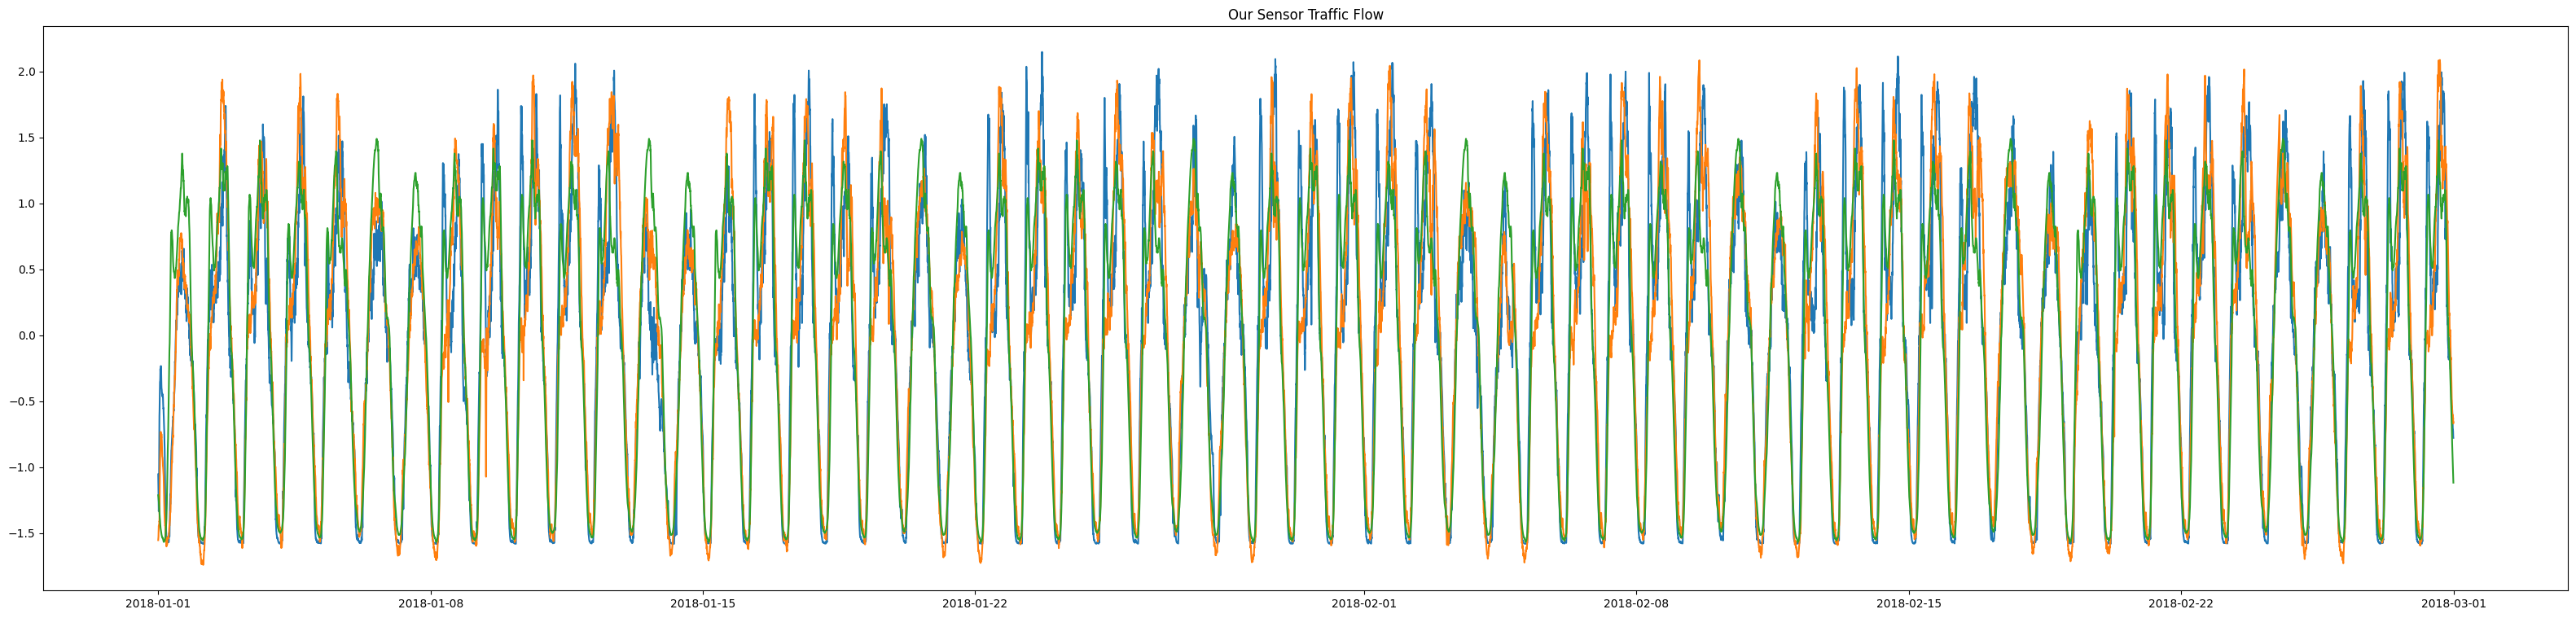

In [8]:
plt.figure(figsize = (40,9))
plt.plot(PeMS[118])
plt.plot(PeMS[168])
plt.plot(PeMS[261])
plt.title('Our Sensor Traffic Flow')
plt.show()

In [9]:
# Federated Learning Experiment

datadict = local_dataset(PeMS[[118,168,261]],3,len(PeMS[[118,168,261]]))
main_model = LSTMModel(input_size=1,hidden_size=32,output_size=1, num_layers=6)


# Local Training

In [11]:
# Training Local
from src.models import LSTMModel, train_model
train_losses = {}
val_losses = {}
for j in range(3):
    new_model = LSTMModel(1,32,1) 
    data_dict = datadict[j]
    new_model, train_losses[j], val_losses[j] = train_model(new_model, data_dict['train'], data_dict['val'], model_path ='./local{}.pth'.format(j),num_epochs=80, remove = False)

Epoch 1/80, Training Loss: 457.5506, Validation Loss: 1.1440
Epoch 2/80, Training Loss: 392.8915, Validation Loss: 1.0480
Epoch 3/80, Training Loss: 373.6378, Validation Loss: 1.0227
Epoch 4/80, Training Loss: 368.7935, Validation Loss: 1.0162
Epoch 5/80, Training Loss: 367.6198, Validation Loss: 1.0145
Epoch 6/80, Training Loss: 367.3442, Validation Loss: 1.0140
Epoch 7/80, Training Loss: 367.2823, Validation Loss: 1.0139
Epoch 8/80, Training Loss: 367.2687, Validation Loss: 1.0139
Epoch 9/80, Training Loss: 367.2640, Validation Loss: 1.0140
Epoch 10/80, Training Loss: 367.2575, Validation Loss: 1.0140
Epoch 11/80, Training Loss: 367.2372, Validation Loss: 1.0142
Epoch 12/80, Training Loss: 367.0632, Validation Loss: 1.0139
Epoch 13/80, Training Loss: 365.6672, Validation Loss: 1.0080
Epoch 14/80, Training Loss: 359.4608, Validation Loss: 0.9803
Epoch 15/80, Training Loss: 341.3086, Validation Loss: 0.9100
Epoch 16/80, Training Loss: 310.1456, Validation Loss: 0.8164
Epoch 17/80, Trai

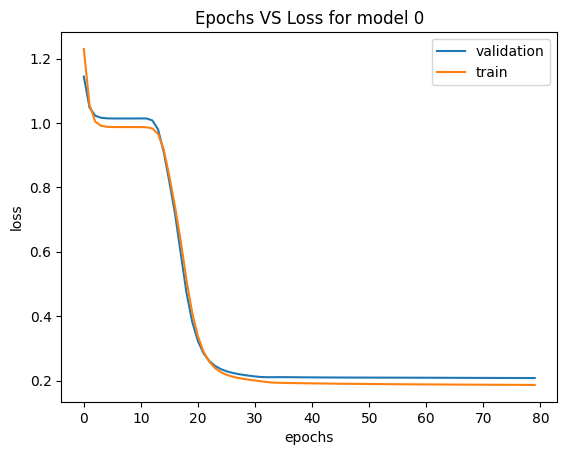

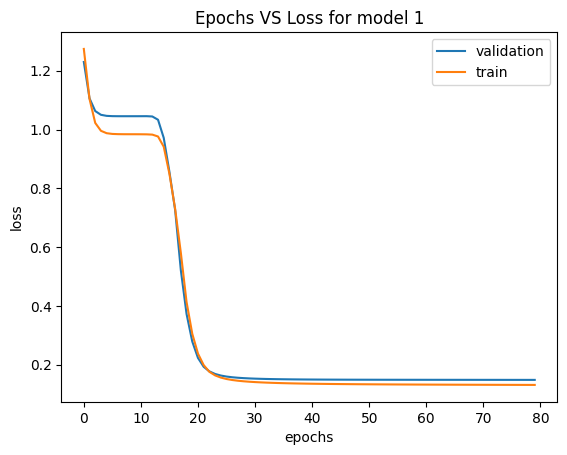

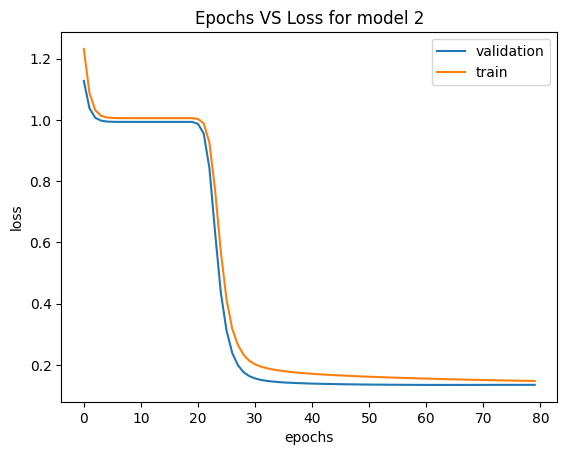

In [12]:
for j in range(3):
    plt.plot(val_losses[j],label='validation')
    plt.plot(train_losses[j],label= 'train')
    plt.title(f"Epochs VS Loss for model {j}")
    plt.xlabel('epochs')
    plt.ylabel("loss")
    plt.legend()
    plt.show()

# FED-TRAINING

In [ ]:
fed_training_plan(datadict, rounds=50, epoch=50)

# Testing

In [15]:
y_true, y_pred = testmodel(new_model,data_dict['test'], None, meanstd_dict,sensor_order_list=[118])

In [18]:
y_true, y_pred = testmodel(new_model,data_dict['test'],'local0.pth', meanstd_dict,sensor_order_list=[118])

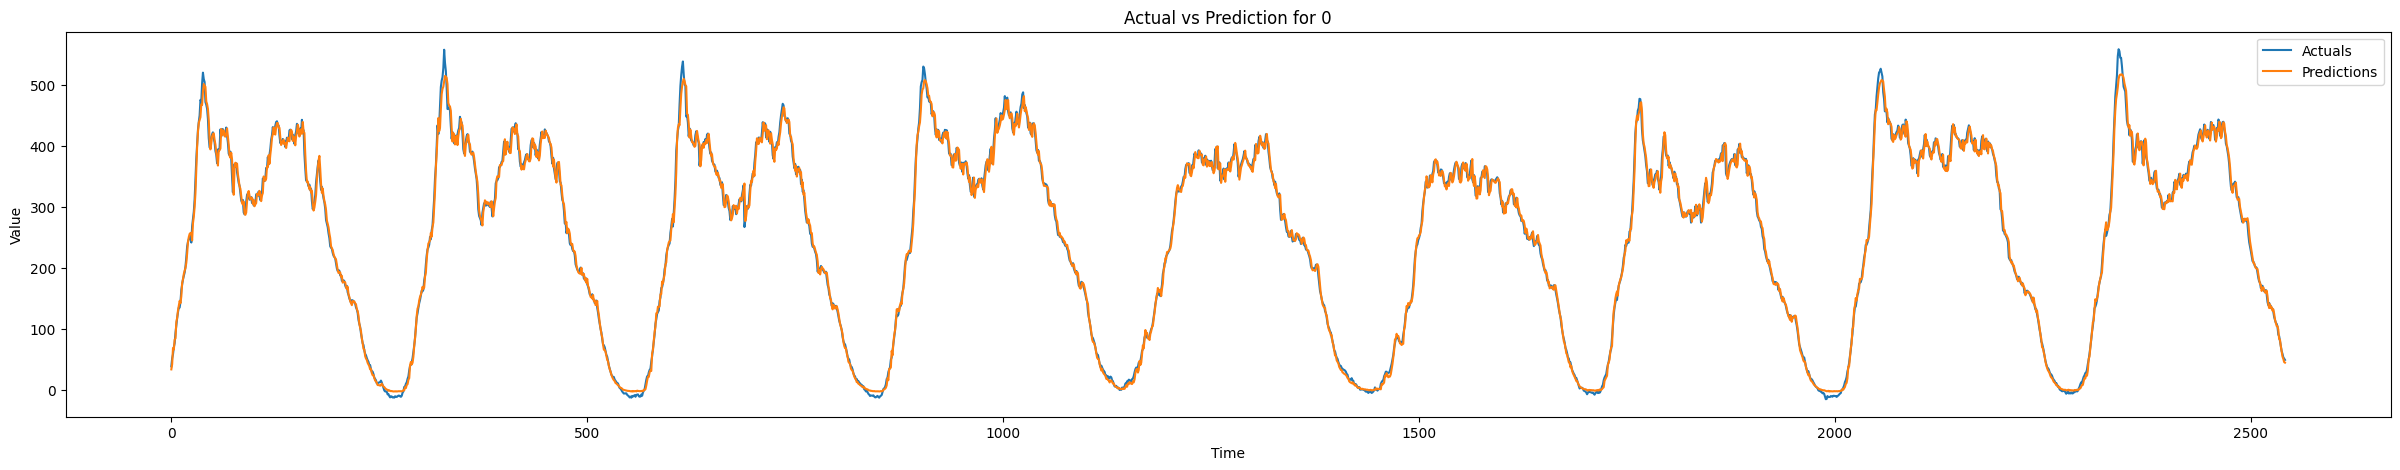

In [19]:
plot_prediction(y_true,y_pred)

In [20]:
calculate_metrics(y_true,y_pred,1)

{'RMSE': 5.050831260574199,
 'RMSPE': 12.52534761051614,
 'MAE': 5.050831260574199,
 'MAPE': 12.52534761051614,
 'MAAPE': 12.460456322854526}